In [1]:
# @Author: xie
# @Date:   2025-06-20
# @Email:  xie@umd.edu
# @Last modified by:   xie
# @Last modified time: 2025-06-20
# @License: MIT License

'''
GeoRF_main.py - Updated with Polygon Contiguity Support

This file shows an example on how to define, train and evaluate a GeoRF model with both grid-based and polygon-based contiguity support.
The general usage is similar to standard machine learning models, with fit(), predict() and evaluate() functions.
The main difference is that GeoRF is a spatially-explicit model, which means location info is needed as part of inputs.

Usage:
    There are 4 key steps:
        (1) Data loading: Prepare standard X, y, as well as locations X_loc
        (2) Define groups using GroupGenerator() or PolygonGroupGenerator() for your data: 
            - Grid-based grouping: Uses regular grid cells as spatial units
            - Polygon-based grouping: Uses administrative boundaries or other polygons as spatial units
        (3) Training: georf.fit() with appropriate contiguity parameters
        (4) Prediction and evaluation: georf.predict() and georf.evaluate()

NEW POLYGON CONTIGUITY FEATURES:
    - PolygonGroupGenerator class for creating polygon-based groups
    - Contiguity refinement using centroid-based neighbor detection
    - Majority voting refinement similar to grid-based system
    - Support for both single-layer and 2-layer models
    - Automatic contiguity type detection based on grouping method

Example usage with polygon contiguity:
    ```python
    # For polygon-based grouping
    polygon_gen = PolygonGroupGenerator(
        polygon_centroids=polygon_centroids,
        neighbor_distance_threshold=0.8
    )
    X_group = polygon_gen.get_groups(X_polygon_ids)
    contiguity_info = polygon_gen.get_contiguity_info()
    
    # Train with polygon contiguity
    georf.fit(X_train, y_train, X_group_train,
              contiguity_type='polygon',
              polygon_contiguity_info=contiguity_info)
    ```

For visualizations, code for grid-based grouping is provided. For polygon-based grouping, 
users can implement custom visualization functions based on their polygon data.
'''

import numpy as np
from scipy import stats
import pandas as pd
import os
import argparse
import sys
#GeoRF
#Can be customized with the template
from GeoRF import GeoRF
from customize import *
from data import load_demo_data#load_data_us_cdl
from helper import get_spatial_range
from initialization import train_test_split_all
#All global parameters
from config import *
from sklearn.impute import SimpleImputer
import polars as pl
# import machine learning metrics, precision, recall and f1_score
from sklearn.metrics import precision_score, recall_score, f1_score
from customize import PolygonGroupGenerator

data = pl.read_csv(r"C:\Users\swl00\IFPRI Dropbox\Weilun Shi\Google fund\Analysis\1.Source Data\FEWSNET_IPC_train_lag_forecast_v06252025.csv")
# drop ISO3, fews_ipc_adjusted, fews_proj_med_adjusted, fews_ipc,fews_proj_near, fews_proj_near_ha, fews_proj_med, fews_proj_med_ha, ADMIN0, ADMIN1,ADMIN2,ADMIN3,ISO

In [2]:
# customize function
def comp_impute(X, strategy = "max_plus", multiplier = 100.0):
    # loop over X columns, replace inf with missing
    for _ in range(X.shape[1]):
        print(f"Checking column {_} for inf values")
        # Try to convert column to float, ignore errors (non-convertible values remain unchanged)
        col_data = X[:, _]
        try:
            col_data_float = col_data.astype(float)
            if np.isinf(col_data_float).any():
                print(f"Column {_} has inf values, replacing with NaN")
                col_data_float[np.isinf(col_data_float)] = np.nan
                X[:, _] = col_data_float
        except Exception as e:
            print(f"Column {_} could not be converted to float: {e}")
            # Skip columns that cannot be converted
            continue
    X_imputed, imputer = impute_missing_values(X, strategy=strategy, multiplier=multiplier, verbose=True)
    X = X_imputed
    return X

In [ ]:
# determine xmin,xmax,ymin and ymax first before runing model

In [3]:
# Data Preprocessing
cols_to_drop = [
        "ISO3", "fews_ipc_adjusted", "fews_proj_med_adjusted", "fews_ipc",
        "fews_proj_near", "fews_proj_near_ha", "fews_proj_med",
        "fews_proj_med_ha", "ADMIN0", "ADMIN1", "ADMIN2", "ADMIN3"
    ]
data = data.drop(cols_to_drop)
less_var = True
if less_var:
    var_extra = ['Evap_tavg_mean',
    'Qsb_tavg_mean',
    'RadT_tavg_mean',
    'SnowCover_inst_mean',
    'SnowDepth_inst_mean',
    'Snowf_tavg_mean',
    'SoilMoi00_10cm_tavg_mean',
    'SoilMoi10_40cm_tavg_mean',
    'SoilMoi100_200cm_tavg_mean',
    'SoilMoi40_100cm_tavg_mean',
    'LWdown_f_tavg_mean',
    'SoilTemp00_10cm_tavg_mean',
    'SoilTemp10_40cm_tavg_mean',
    'SoilTemp100_200cm_tavg_mean',
    'SoilTemp40_100cm_tavg_mean',
    'SWdown_f_tavg_mean',
    'SWE_inst_mean',
    'Swnet_tavg_mean',
    'Wind_f_tavg_mean',
    'Lwnet_tavg_mean',
    'Psurf_f_tavg_mean',
    'Qair_f_tavg_mean',
    'Qg_tavg_mean',
    'Qh_tavg_mean',
    'Qle_tavg_mean',
    'Qs_tavg_mean']
    # drop any columns start with var_extra
    data = data.drop([col for col in data.columns if col.startswith(tuple(var_extra))])
    


# keep only fews_ipc_crisis is not null
data = data.filter(pl.col("fews_ipc_crisis").is_not_null())

# encode ISO
data = data.with_columns([
    pl.col("ISO").cast(pl.Categorical).to_physical().alias("ISO_encoded")
])

# drop unit name, ISO
data = data.drop(["unit_name", "ISO"])
# for AEZ_* replace "False" with 0 and "True" with 1
for col in data.columns:
    if col.startswith("AEZ_"):
        data = data.with_columns(
            pl.when(pl.col(col) == "True")
            .then(1)
            .when(pl.col(col) == "False")
            .then(0)
            .otherwise(pl.col(col))
            .alias(col)
        )


df = data.to_pandas()
df['date'] = pd.to_datetime(df['date'])
df['years'] = df['date'].dt.year
df['fews_ipc_crisis_lag_1'] = df.groupby('FEWSNET_admin_code')['fews_ipc_crisis'].shift(1)
df['fews_ipc_crisis_lag_2']= df.groupby('FEWSNET_admin_code')['fews_ipc_crisis'].shift(2)
df['fews_ipc_crisis_lag_3'] = df.groupby('FEWSNET_admin_code')['fews_ipc_crisis'].shift(3)
# generate dummys for year month
for year in df['years'].unique():
    df[f'year_{year}'] = (df['years'] == year).astype(int)
for month in df['date'].dt.month.unique():
    df[f'month_{month}'] = (df['date'].dt.month == month).astype(int)




X_loc = df[['lat', 'lon']].values



aez_columns = [col for col in df.columns if col.startswith('AEZ_')]
df['AEZ_group'] = df.groupby(aez_columns).ngroup()
df['AEZ_country_group'] = df.groupby(['AEZ_group', 'ISO_encoded']).ngroup()

In [4]:
#prepare groups (minimum spatial units for space-partitioning and location groupings, e.g., using a grid)
assignment = 'polygons' # if polygons is True, use FEWSNET_admin_code as groups, otherwise use grid-based grouping
#extract the values of FEWSNET_admin_code and assign to X_group
if assignment=='polygons':
    X_polygon_ids = df['FEWSNET_admin_code'].values
    
    # Get unique polygons and their centroids
    polygon_data = df[['FEWSNET_admin_code', 'lat', 'lon']].drop_duplicates()
    polygon_centroids = polygon_data[['lat', 'lon']].values
    
    # Get unique admin codes
    unique_polygons = polygon_data['FEWSNET_admin_code'].unique()
    
    # Create mapping from FEWSNET_admin_code to polygon index
    admin_to_polygon_idx = {admin_code: idx for idx, admin_code in enumerate(unique_polygons)}
    
    # FIXED: Create correct polygon_group_mapping
    # Map polygon_index -> [admin_code] (each polygon is its own group using admin code as group ID)
    polygon_group_mapping = {i: [unique_polygons[i]] for i in range(len(unique_polygons))}
    
    # Convert admin codes to polygon indices for PolygonGroupGenerator
    polygon_indices = np.array([admin_to_polygon_idx[admin_code] for admin_code in X_polygon_ids])
    
    # Create polygon generator with correct mapping
    polygon_gen = PolygonGroupGenerator(
        polygon_centroids=polygon_centroids,
        polygon_group_mapping=polygon_group_mapping,
        neighbor_distance_threshold=0.8
    )
    
    # Generate groups (these will be admin codes, not indices!)
    X_group = polygon_gen.get_groups(polygon_indices)
    contiguity_info = polygon_gen.get_contiguity_info()
    
    print(f"Polygon setup complete: {len(unique_polygons)} polygons, {len(np.unique(X_group))} groups")
    print(f"X_group range: {X_group.min()} to {X_group.max()}")
    print(f"Contiguity info keys: {list(contiguity_info.keys())}")
    
    # Validation
    assert len(np.unique(X_group)) == len(unique_polygons), "Number of groups should equal number of polygons"
    assert set(X_group) == set(unique_polygons), "Group IDs should be admin codes"
    print("Validation passed!")

elif assignment=='grid':
    #prepare groups (minimum spatial units for space-partitioning and location groupings, e.g., using a grid)
    xmin, xmax, ymin, ymax = get_spatial_range(X_loc)
    STEP_SIZE = 0.1
    group_gen = GroupGenerator(xmin, xmax, ymin, ymax, STEP_SIZE)
    X_group = group_gen.get_groups(X_loc)
    contiguity_info = None  # Grid-based doesn't need special contiguity info
    
elif assignment=='country':
    X_group = df['ISO_encoded'].values
    X_group = X_group.astype(int)
    contiguity_info = None
    
elif assignment=='AEZ':
    X_group = df['AEZ_group'].values
    X_group = X_group.astype(int)
    contiguity_info = None
    
elif assignment=='country_AEZ':
    X_group = df['AEZ_country_group'].values
    X_group = X_group.astype(int)
    contiguity_info = None
    
elif assignment=='geokmeans':
    cluster_id, cluster_info, admin_to_group_map = create_kmeans_groupgenerator_from_admin_codes(df, n_clusters=100, random_state=42, features_for_clustering=['lat', 'lon'])
    X_group=cluster_id
    X_group = X_group.astype(int)
    contiguity_info = None
    # from admin_to_group_map, create a correspondence table, its index is FEWSNET_admin_code, and column is cluster_id
    correspondence_table = pd.DataFrame(list(admin_to_group_map.items()), columns=['FEWSNET_admin_code', 'cluster_id'])
    correspondence_table.to_csv('correspondence_table_geokmeans.csv', index=False)
    
elif assignment=='all_kmeans':
    X_columns = df.drop(columns=['FEWSNET_admin_code', 'lat', 'lon', 'fews_ipc_crisis']).columns.tolist()
    cluster_id, cluster_info, admin_to_group_map = create_kmeans_groupgenerator_from_admin_codes(df, n_clusters=100, random_state=42, features_for_clustering=X_columns)
    X_group = cluster_id
    X_group = X_group.astype(int)
    contiguity_info = None
    correspondence_table = pd.DataFrame(list(admin_to_group_map.items()), columns=['FEWSNET_admin_code', 'cluster_id'])
    correspondence_table.to_csv('correspondence_table_allkmeans.csv', index=False)
else:
    raise ValueError(f"Unknown assignment method: {assignment}")

y = df['fews_ipc_crisis'].values

# save correspondence table
correspondence_table = df[['FEWSNET_admin_code', 'AEZ_group', 'AEZ_country_group', 'ISO_encoded']].drop_duplicates()
correspondence_table.to_csv('correspondence_table.csv', index=False)

# sort by FEWSNET_admin_code and date
df = df.sort_values(by=['FEWSNET_admin_code', 'date'])
# for each FEWSNET_admin_code, created lagged fews_ipc_crisis for 1,2 and 3 terms
for lag in range(1, 4):
    df[f'fews_ipc_crisis_lag_{lag}'] = df.groupby('FEWSNET_admin_code')['fews_ipc_crisis'].shift(lag)
# drop date
df = df.drop(columns=['date'])
df=df.drop(columns=['fews_ipc_crisis','AEZ_group','ISO_encoded','AEZ_country_group'])
time_variants =  ['event_count_battles', 'event_count_explosions', 'event_count_violence', 'sum_fatalities_battles', 'sum_fatalities_explosions', 'sum_fatalities_violence', 'event_count_battles_w5', 'event_count_explosions_w5', 'event_count_violence_w5', 'sum_fatalities_battles_w5', 'sum_fatalities_explosions_w5', 'sum_fatalities_violence_w5', 'event_count_battles_w10', 'event_count_explosions_w10', 'event_count_violence_w10', 'sum_fatalities_battles_w10', 'sum_fatalities_explosions_w10', 'sum_fatalities_violence_w10', 'nightlight', 'nightlight_sd', 'EVI', 'EVI_stdDev',  'FAO_price', 'Evap_tavg_mean', 'Evap_tavg_stdDev', 'LWdown_f_tavg_mean', 'LWdown_f_tavg_stdDev', 'Lwnet_tavg_mean', 'Lwnet_tavg_stdDev', 'Psurf_f_tavg_mean', 'Psurf_f_tavg_stdDev', 'Qair_f_tavg_mean', 'Qair_f_tavg_stdDev', 'Qg_tavg_mean', 'Qg_tavg_stdDev', 'Qh_tavg_mean', 'Qh_tavg_stdDev', 'Qle_tavg_mean', 'Qle_tavg_stdDev', 'Qs_tavg_mean', 'Qs_tavg_stdDev', 'Qsb_tavg_mean', 'Qsb_tavg_stdDev', 'RadT_tavg_mean', 'RadT_tavg_stdDev', 'Rainf_f_tavg_mean', 'Rainf_f_tavg_stdDev', 'SnowCover_inst_mean', 'SnowCover_inst_stdDev', 'SnowDepth_inst_mean', 'SnowDepth_inst_stdDev', 'Snowf_tavg_mean', 'Snowf_tavg_stdDev', 'SoilMoi00_10cm_tavg_mean', 'SoilMoi00_10cm_tavg_stdDev', 'SoilMoi10_40cm_tavg_mean', 'SoilMoi10_40cm_tavg_stdDev', 'SoilMoi100_200cm_tavg_mean', 'SoilMoi100_200cm_tavg_stdDev', 'SoilMoi40_100cm_tavg_mean', 'SoilMoi40_100cm_tavg_stdDev', 'SoilTemp00_10cm_tavg_mean', 'SoilTemp00_10cm_tavg_stdDev', 'SoilTemp10_40cm_tavg_mean', 'SoilTemp10_40cm_tavg_stdDev', 'SoilTemp100_200cm_tavg_mean', 'SoilTemp100_200cm_tavg_stdDev', 'SoilTemp40_100cm_tavg_mean', 'SoilTemp40_100cm_tavg_stdDev', 'SWdown_f_tavg_mean', 'SWdown_f_tavg_stdDev', 'SWE_inst_mean', 'SWE_inst_stdDev', 'Swnet_tavg_mean', 'Swnet_tavg_stdDev', 'Tair_f_tavg_mean', 'Tair_f_tavg_stdDev', 'Wind_f_tavg_mean', 'Wind_f_tavg_stdDev', 'gpp_sd', 'gpp_mean', 'CPI', 'GDP', 'CC', 'gini', 'WFP_Price', 'WFP_Price_std']
time_variants_m12 = [variant + '_m12' for variant in time_variants]
time_variants_list = time_variants + time_variants_m12
l2_index = []
# if columns in time_variants_list, record its index and restore in l2_index
for i, col in enumerate(df.columns):
    if col in time_variants_list:
        l2_index.append(i)

PolygonGroupGenerator initialized with 4081 polygons and 4081 groups
Polygon setup complete: 4081 polygons, 4081 groups
X_group range: 0 to 5652
Contiguity info keys: ['polygon_centroids', 'polygon_group_mapping', 'neighbor_distance_threshold']
Validation passed!


In [5]:
# l1 index is all columns except l2 index
l1_index = [i for i in range(df.shape[1]) if i not in l2_index]

X = df.values
X = comp_impute(X)

Checking column 0 for inf values
Checking column 1 for inf values
Checking column 2 for inf values
Checking column 3 for inf values
Checking column 4 for inf values
Checking column 5 for inf values
Checking column 6 for inf values
Checking column 7 for inf values
Checking column 8 for inf values
Checking column 9 for inf values
Checking column 10 for inf values
Checking column 11 for inf values
Checking column 12 for inf values
Checking column 13 for inf values
Checking column 14 for inf values
Checking column 15 for inf values
Checking column 16 for inf values
Checking column 17 for inf values
Checking column 18 for inf values
Checking column 19 for inf values
Checking column 20 for inf values
Checking column 21 for inf values
Checking column 22 for inf values
Checking column 23 for inf values
Checking column 24 for inf values
Checking column 25 for inf values
Checking column 26 for inf values
Checking column 27 for inf values
Checking column 28 for inf values
Checking column 29 for i

In [6]:
# Polygon contiguity validation and debugging (optional)
if assignment == 'polygons':
    print("=== Polygon Contiguity Validation ===")
    
    # Check polygon neighbor relationships
    from partition_opt import get_polygon_neighbors
    
    neighbors = get_polygon_neighbors(contiguity_info['polygon_centroids'], 
                                     contiguity_info['neighbor_distance_threshold'])
    neighbor_counts = [len(n) for n in neighbors.values()]
    
    print(f"Neighbor stats: min={min(neighbor_counts)}, max={max(neighbor_counts)}, "
          f"mean={np.mean(neighbor_counts):.1f}")
    
    # Check for isolated polygons (no neighbors)
    isolated_polygons = [poly_id for poly_id, neighs in neighbors.items() if len(neighs) == 0]
    if len(isolated_polygons) > 0:
        print(f"Warning: {len(isolated_polygons)} isolated polygons: {isolated_polygons}")
    
    # Check centroids
    centroids = contiguity_info['polygon_centroids']
    print(f"Centroid range: lat {centroids[:, 0].min():.2f}-{centroids[:, 0].max():.2f}, "
          f"lon {centroids[:, 1].min():.2f}-{centroids[:, 1].max():.2f}")
    
    # Check group sizes
    group_sizes = pd.Series(X_group).value_counts()
    print(f"Group size stats: min={group_sizes.min()}, max={group_sizes.max()}, "
          f"mean={group_sizes.mean():.1f}")
    
    # Very small groups may cause issues
    small_groups = group_sizes[group_sizes < 10]
    if len(small_groups) > 0:
        print(f"Warning: {len(small_groups)} groups have <10 samples")
    
    print("=== End Polygon Validation ===\n")

# Initialize results tracking
nowcasting = False
max_depth = None
results_df= pd.DataFrame(columns=['year','precision(0)', 'recall(0)', 'f1(0)', 'precision(1)', 'recall(1)', 'f1(1)', 'precision_base(0)', 'recall_base(0)', 'f1_base(0)', 'precision_base(1)', 'recall_base(1)', 'f1_base(1)',
                                  'num_samples(0)','num_samples(1)'])

y_pred_test = pd.DataFrame(columns=['year', 'month','adm_code','fews_ipc_crisis_pred','fews_ipc_crisis_true'])

#train test split preparation complete

=== Polygon Contiguity Validation ===
Neighbor stats: min=0, max=187, mean=28.4
Centroid range: lat -26.66-38.22, lon -92.18-73.34
Group size stats: min=3, max=51, mean=45.3
=== End Polygon Validation ===



model_dir: result_GeoRF_15


c:\Users\swl00\IFPRI Dropbox\Weilun Shi\Google fund\Analysis\2.source_code\Step5_Geo_RF_trial\Food_Crisis_Cluster\helper.py:240: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  s_branch[''][:gid_list.shape[0]] = gid_list
c:\Users\swl00\IFPRI D

model_dir: result_GeoRF_15
Printing to file.


C:\Users\swl00\AppData\Local\Temp\ipykernel_14156\3841968889.py:175: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({
C:\Users\swl00\AppData\Local\Temp\ipykernel_14156\3841968889.py:193: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  y_pred_test = pd.concat([y_pred_test, pd.DataFrame({


model_dir: result_GeoRF_16


c:\Users\swl00\IFPRI Dropbox\Weilun Shi\Google fund\Analysis\2.source_code\Step5_Geo_RF_trial\Food_Crisis_Cluster\helper.py:240: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  s_branch[''][:gid_list.shape[0]] = gid_list
c:\Users\swl00\IFPRI D

model_dir: result_GeoRF_16
Printing to file.
model_dir: result_GeoRF_17


c:\Users\swl00\IFPRI Dropbox\Weilun Shi\Google fund\Analysis\2.source_code\Step5_Geo_RF_trial\Food_Crisis_Cluster\helper.py:240: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  s_branch[''][:gid_list.shape[0]] = gid_list
c:\Users\swl00\IFPRI D

model_dir: result_GeoRF_17
Printing to file.
model_dir: result_GeoRF_18


c:\Users\swl00\IFPRI Dropbox\Weilun Shi\Google fund\Analysis\2.source_code\Step5_Geo_RF_trial\Food_Crisis_Cluster\helper.py:240: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  s_branch[''][:gid_list.shape[0]] = gid_list
c:\Users\swl00\IFPRI D

model_dir: result_GeoRF_18
Printing to file.


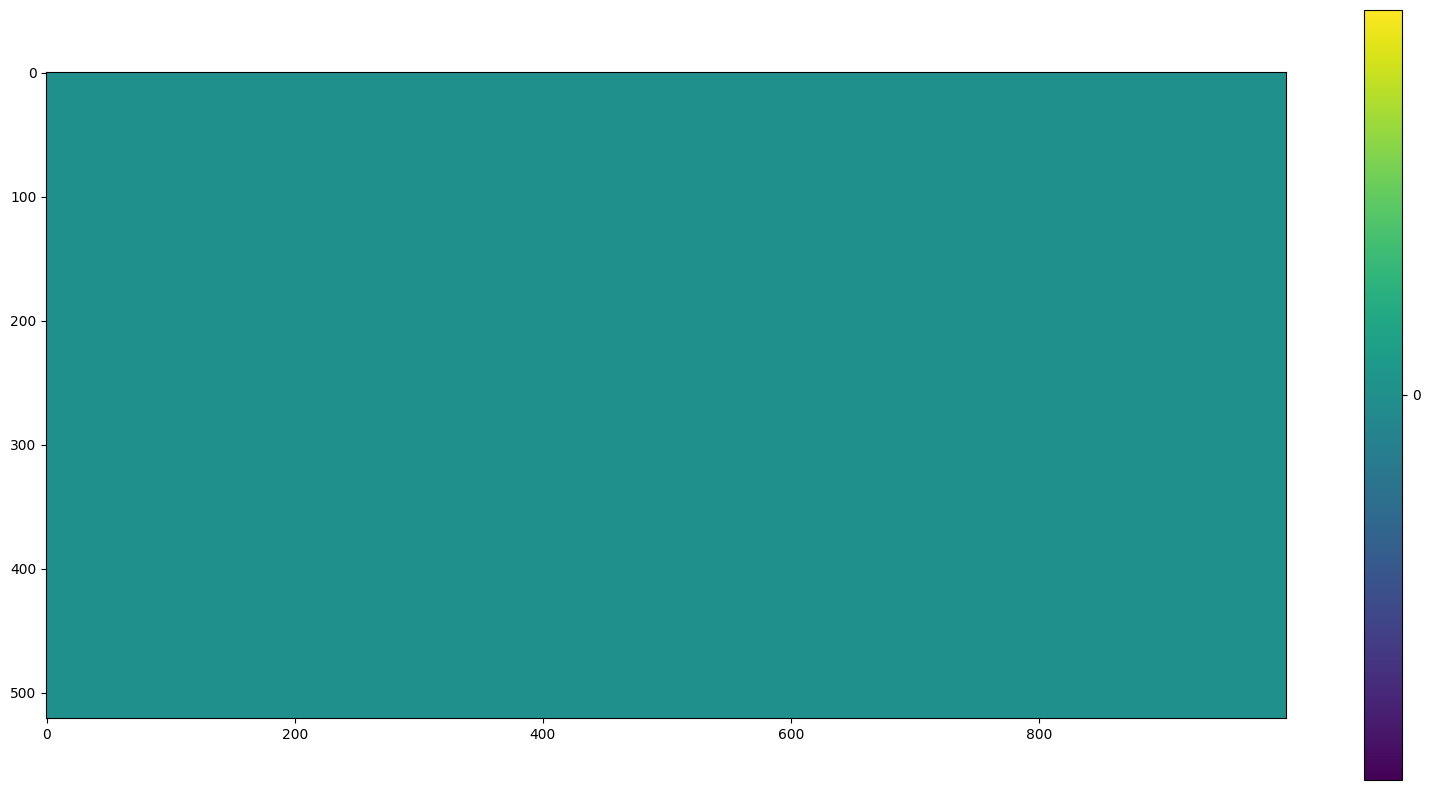

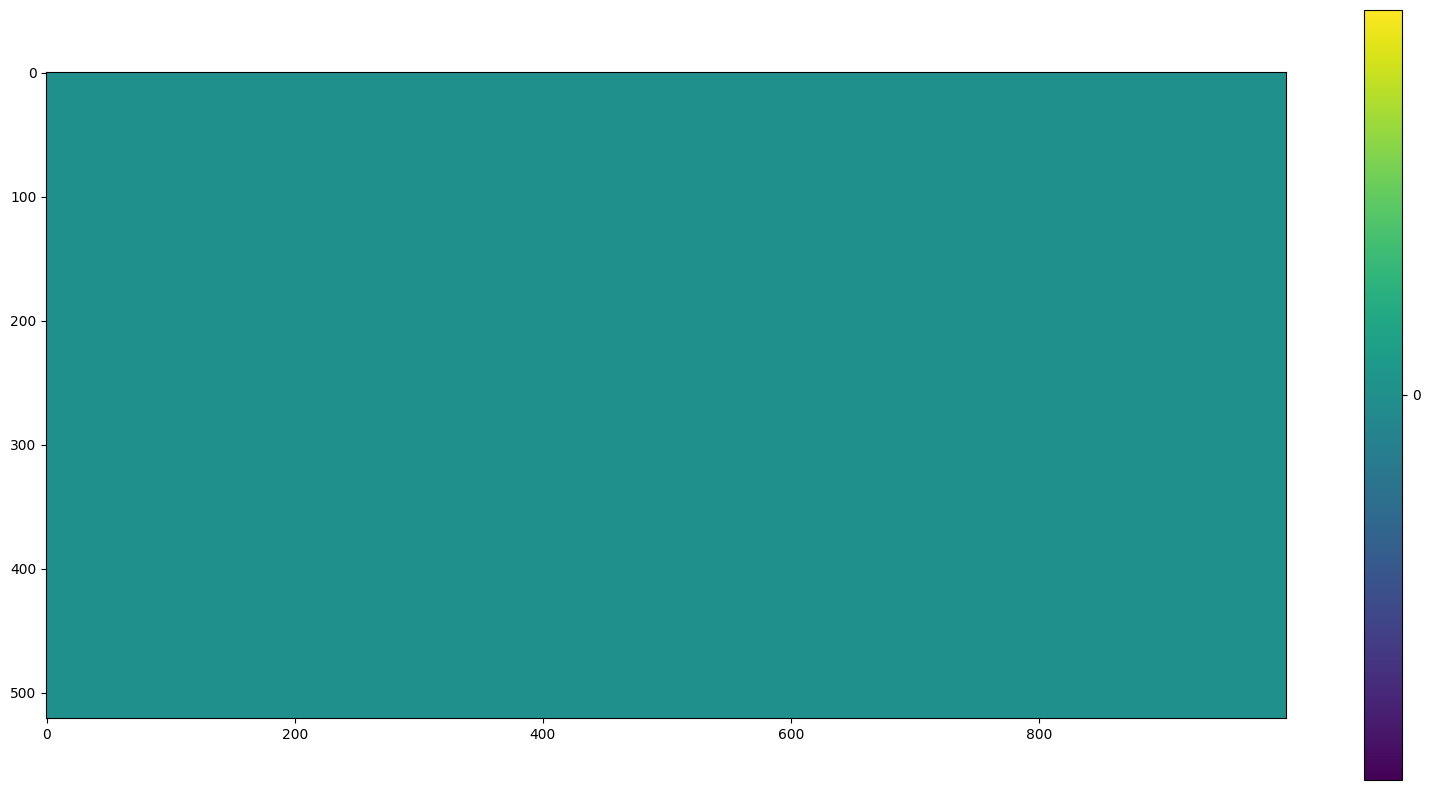

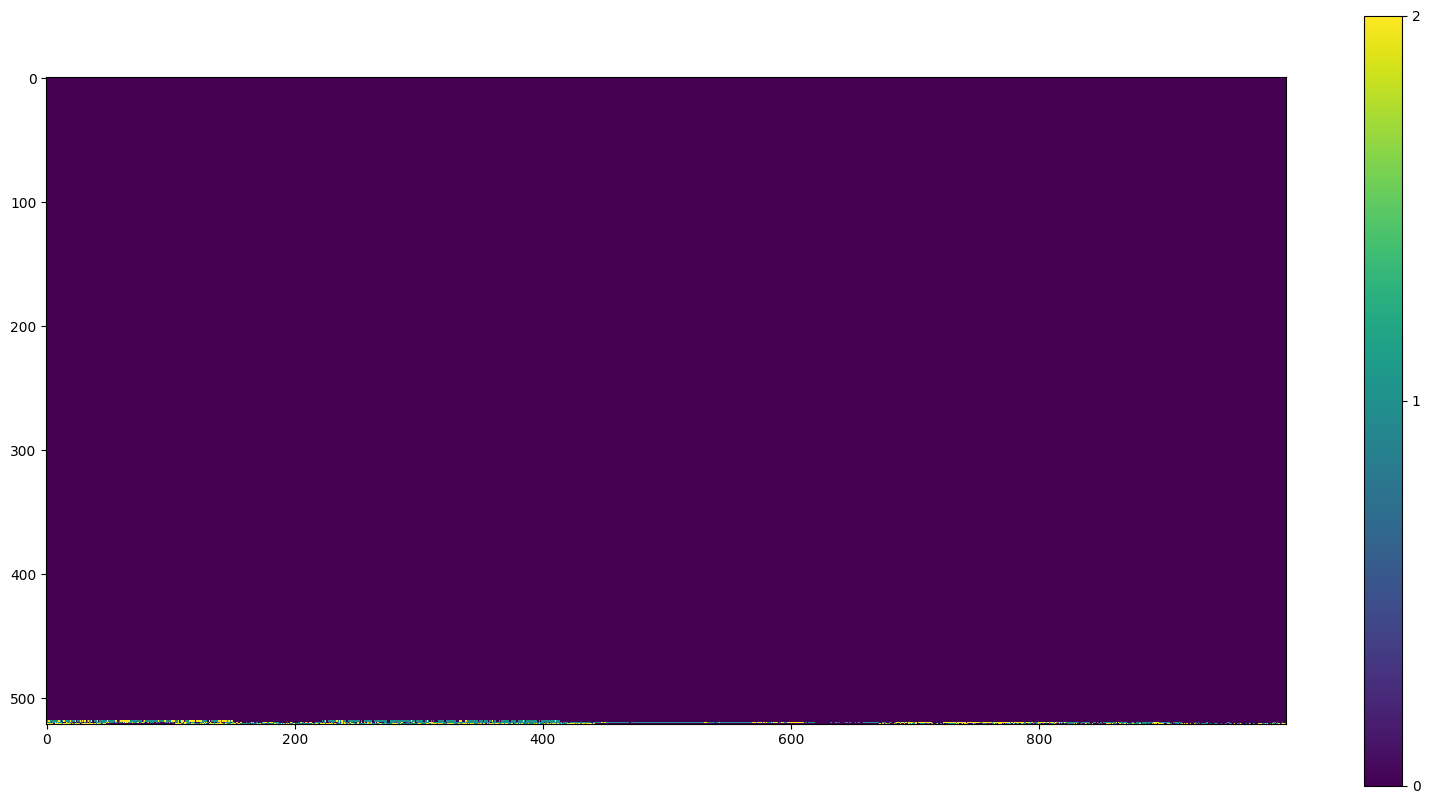

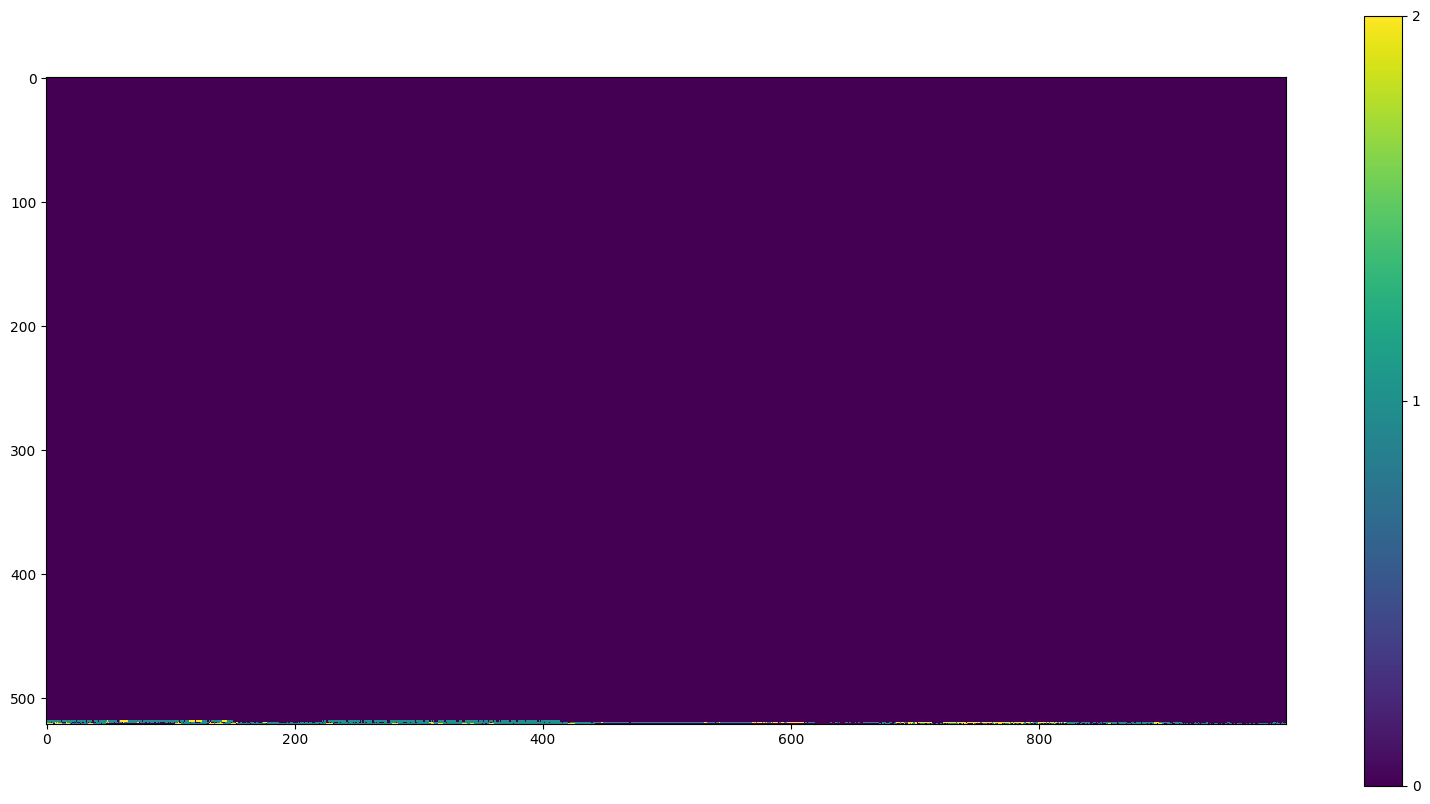

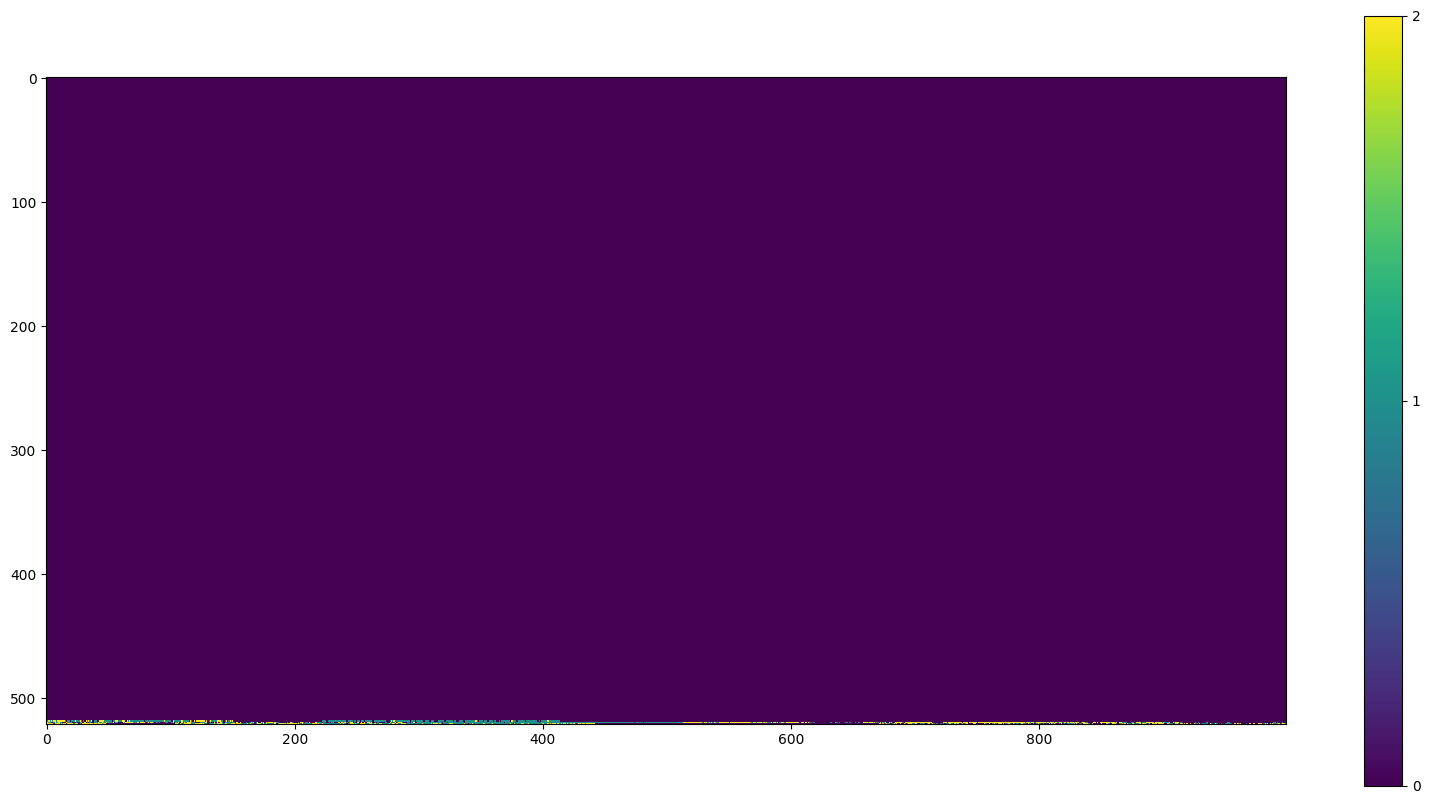

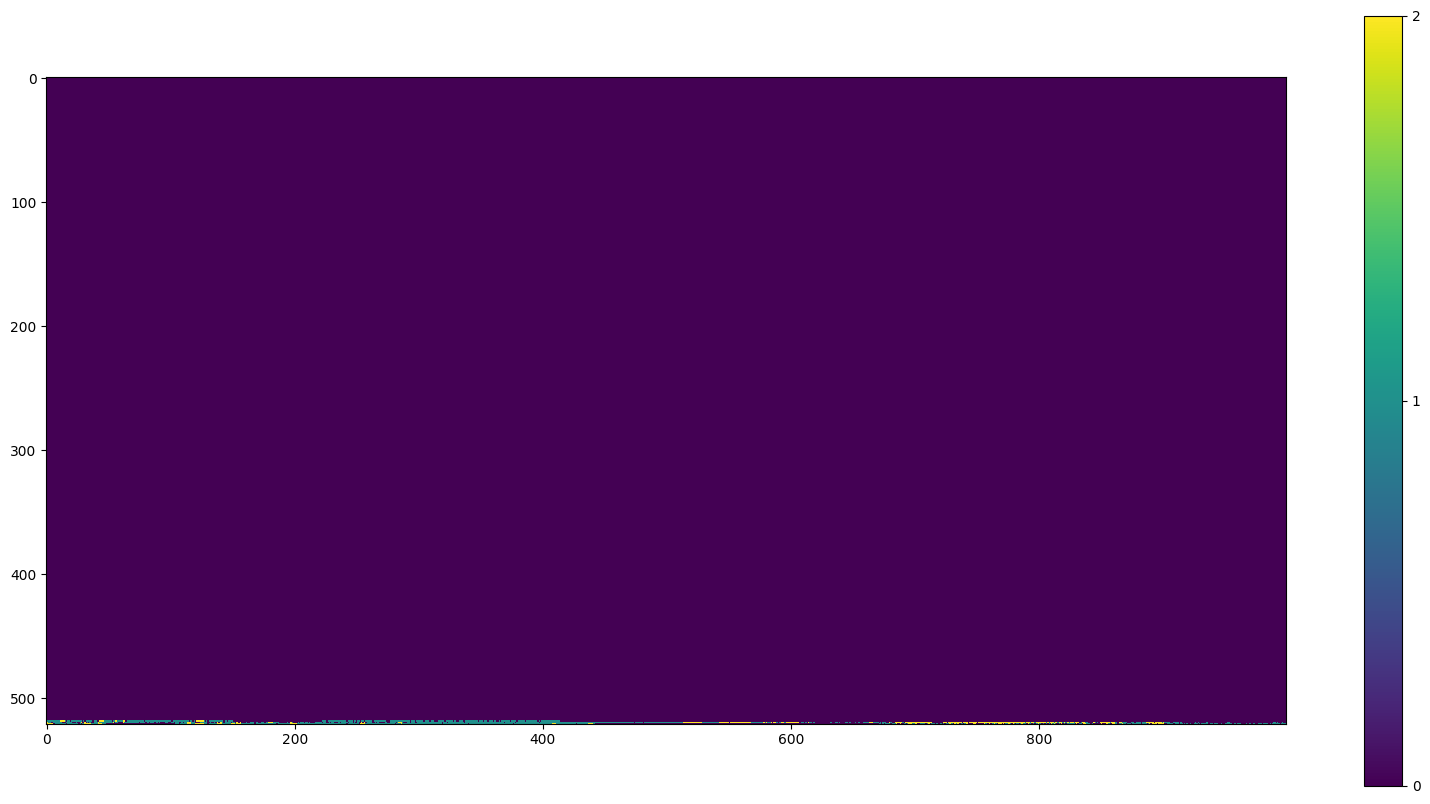

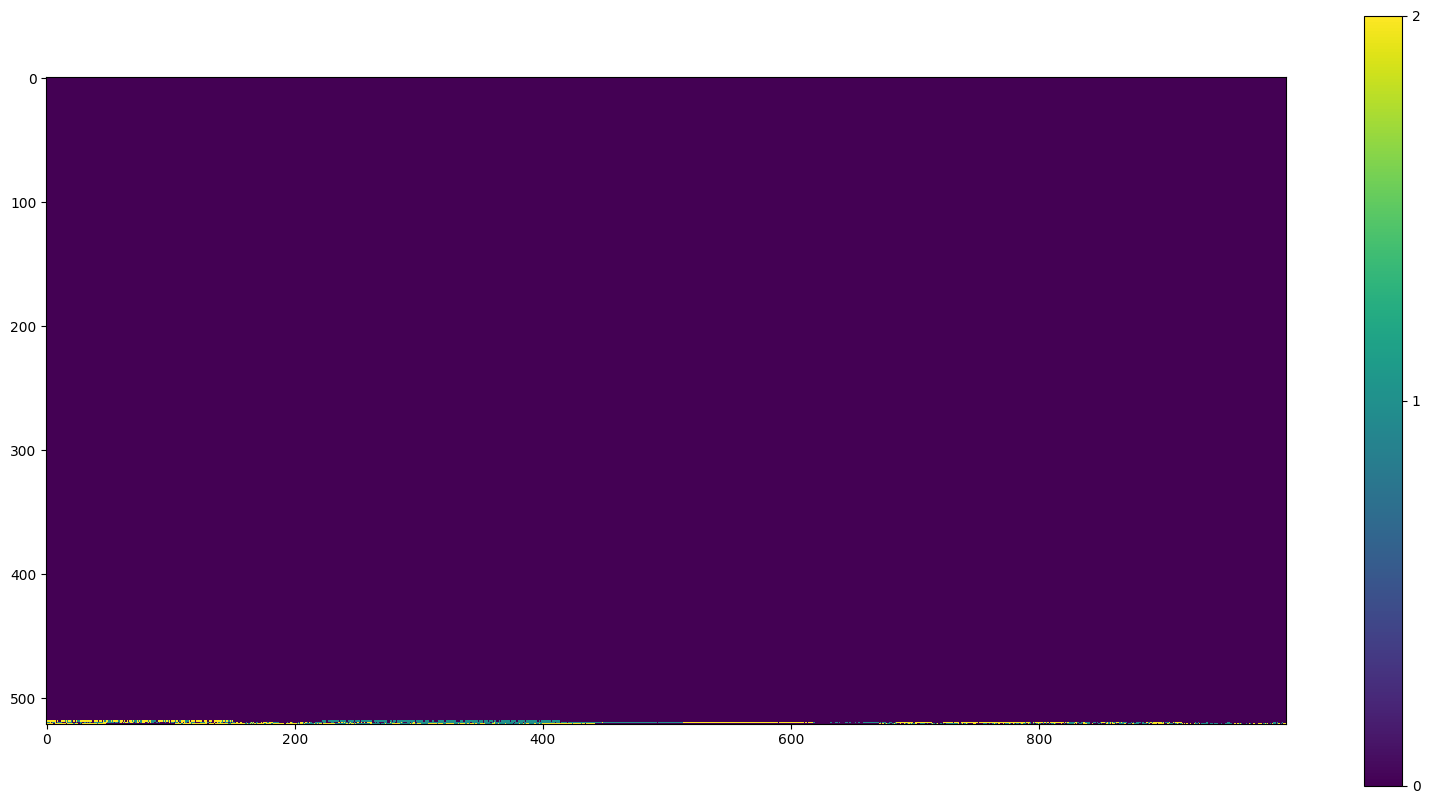

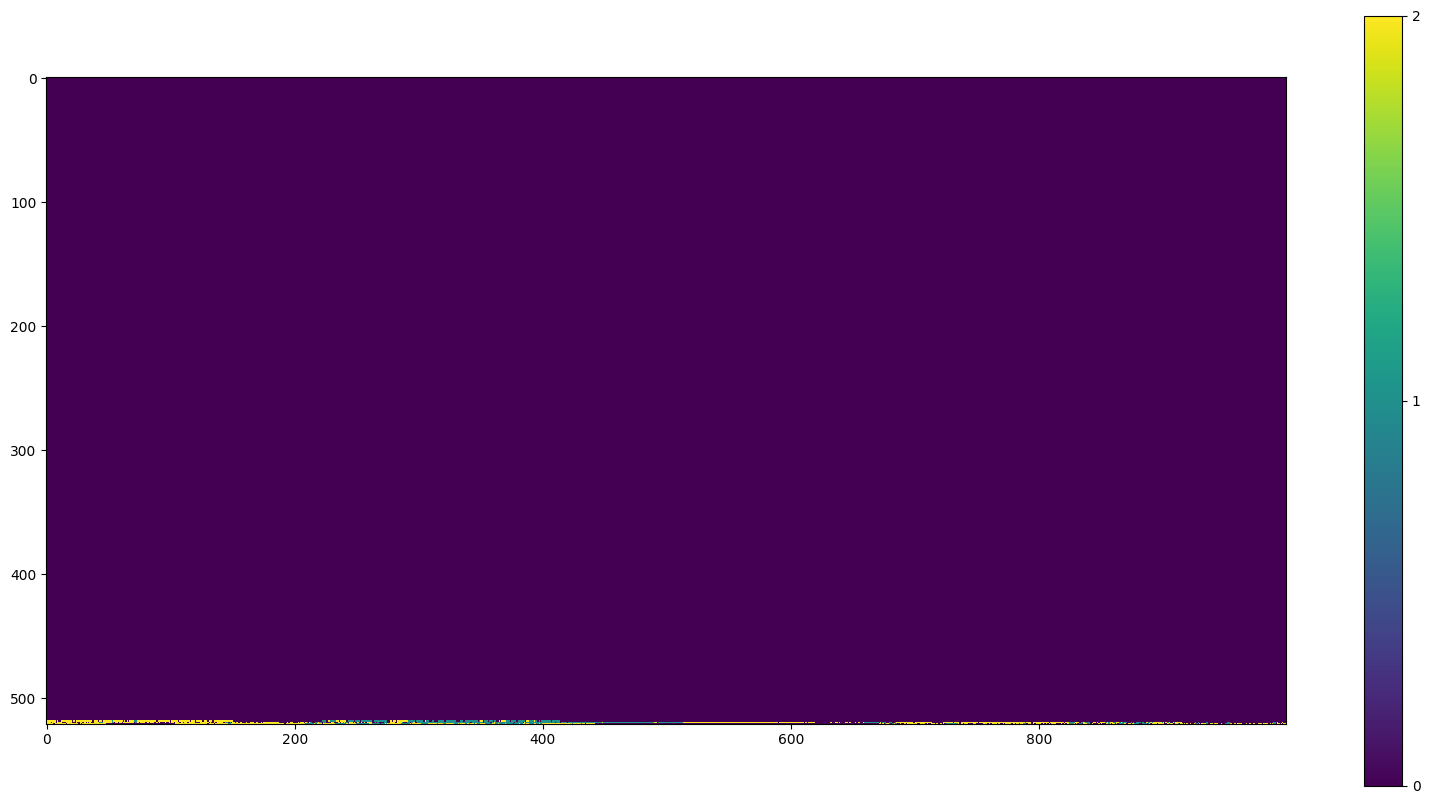

In [7]:
# TODO: why some f1, recall, and sensitivity is higher in the base model?
# TODO： split is unusual.
# TODO: update country, AEZ, country_AEZ for polygon contiguity, update the kmeans function to explicitly use the polygon ID
# Updated main notebook code with consistent 2-layer evaluation

if nowcasting:
    for year in range(2021,2025):
        # Train-test split
        (Xtrain, ytrain, Xtrain_loc, Xtrain_group,
        Xtest, ytest, Xtest_loc, Xtest_group) = train_test_split_by_year(
            X, y, X_loc, X_group, df['years'].values, test_year=year)
        ytrain = ytrain.astype(int)
        ytest  = ytest.astype(int)
        
        # Split features for both layers
        Xtrain_L1 = Xtrain[:, l1_index]
        Xtrain_L2 = Xtrain[:, l2_index]
        Xtest_L1 = Xtest[:, l1_index]
        Xtest_L2 = Xtest[:, l2_index]
        
        # Create and train 2-layer GeoRF model
        georf_2layer = GeoRF(
            min_model_depth=MIN_DEPTH,
            max_model_depth=MAX_DEPTH, 
            n_jobs=N_JOBS,
            max_depth=max_depth
        )
        
        # Determine contiguity type and info based on assignment
        if assignment == 'polygons':
            contiguity_type = 'polygon'
            polygon_contiguity_info = contiguity_info
        else:
            contiguity_type = 'grid'
            polygon_contiguity_info = None
        
        # Train 2-layer model with contiguity
        georf_2layer.fit_2layer(
            Xtrain_L1, Xtrain_L2, ytrain, Xtrain_group, 
            val_ratio=VAL_RATIO,
            contiguity_type=contiguity_type,
            polygon_contiguity_info=polygon_contiguity_info
        )
        
        # Get predictions
        ypred = georf_2layer.predict_2layer(Xtest_L1, Xtest_L2, Xtest_group, correction_strategy='flip')
        
        # Evaluate: This now compares 2-layer GeoRF vs 2-layer Base RF
        (pre, rec, f1, pre_base, rec_base, f1_base) = georf_2layer.evaluate_2layer(
            X_L1_test=Xtest_L1,
            X_L2_test=Xtest_L2, 
            y_test=ytest,
            X_group_test=Xtest_group,
            X_L1_train=Xtrain_L1,
            X_L2_train=Xtrain_L2,
            y_train=ytrain, 
            X_group_train=Xtrain_group,
            correction_strategy='flip',
            print_to_file=True,
            contiguity_type=contiguity_type,
            polygon_contiguity_info=polygon_contiguity_info
        )
        
        # Calculate weighted averages (same as your forecasting model)
        nsample_class = np.bincount(ytest)
        
        # Store results
        results_df = pd.concat([results_df, pd.DataFrame({
            'year': year,
            'precision(0)': pre[0],
            'precision(1)': pre[1],
            'recall(0)': rec[0],
            'recall(1)': rec[1],
            'f1(0)': f1[0],
            'f1(1)': f1[1],
            'precision_base(0)': pre_base[0],
            'precision_base(1)': pre_base[1],
            'recall_base(0)': rec_base[0], 
            'recall_base(1)': rec_base[1],
            'f1_base(0)': f1_base[0],
            'f1_base(1)': f1_base[1],
            'num_samples(0)': nsample_class[0],
            'num_samples(1)': nsample_class[1]
        }, index=[0])], ignore_index=True)
        
        y_pred_test = pd.concat([y_pred_test, pd.DataFrame({
            'year': year, 
            'month': Xtest[:,1], 
            'adm_code': Xtest[:,0], 
            'fews_ipc_crisis_pred': ypred, 
            'fews_ipc_crisis_true': ytest
        })], ignore_index=True)
        
        print(f"Year {year} - 2-Layer GeoRF F1: {f1:.4f}, 2-Layer Base RF F1: {f1_base:.4f}")
        
    # Set file naming based on assignment type
    pred_test_name = 'y_pred_test_g'
    results_df_name = 'results_df_g'
    if assignment=='polygons':
        pred_test_name = pred_test_name + 'pn'
        results_df_name = results_df_name + 'pn'
    elif assignment == 'grid':
        pred_test_name = pred_test_name + 'gn'
        results_df_name = results_df_name + 'gn'
    elif assignment == 'country':
        pred_test_name = pred_test_name + 'cn'
        results_df_name = results_df_name + 'cn'
    elif assignment == 'AEZ':
        pred_test_name = pred_test_name + 'aen'
        results_df_name = results_df_name + 'aen'
    elif assignment == 'country_AEZ':
        pred_test_name = pred_test_name + 'caen'
        results_df_name = results_df_name + 'caen'
    elif assignment == 'geokmeans':
        pred_test_name = pred_test_name + 'gkn'
        results_df_name = results_df_name + 'gkn'
    elif assignment == 'all_kmeans':
        pred_test_name = pred_test_name + 'akn'
        results_df_name = results_df_name + 'akn'
    else:
        raise ValueError(f"Unknown assignment method: {assignment}")

    if max_depth is not None:
        pred_test_name = pred_test_name + f'_d{max_depth}.csv'
        results_df_name = results_df_name + f'_d{max_depth}.csv'
    else:
        pred_test_name = pred_test_name + '.csv'
        results_df_name = results_df_name + '.csv'
    y_pred_test.to_csv(pred_test_name, index=False)
    results_df.to_csv(results_df_name, index=False)

else:
    # Forecasting mode - Single layer with proper contiguity
    for year in range(2021,2025):
        (Xtrain, ytrain, Xtrain_loc, Xtrain_group,
        Xtest, ytest, Xtest_loc, Xtest_group) = train_test_split_by_year(
            X, y, X_loc, X_group, df['years'].values, test_year=year)
        ytrain = ytrain.astype(int)
        ytest  = ytest.astype(int)
        
        # Create GeoRF model
        georf = GeoRF(
            min_model_depth=MIN_DEPTH, 
            max_model_depth=MAX_DEPTH, 
            n_jobs=N_JOBS, 
            max_depth=max_depth
        )
        
        # Determine contiguity type and info based on assignment
        if assignment == 'polygons':
            contiguity_type = 'polygon'
            polygon_contiguity_info = contiguity_info
        else:
            contiguity_type = 'grid'
            polygon_contiguity_info = None
        
        # Train with appropriate contiguity
        georf.fit(
            Xtrain, ytrain, Xtrain_group,
            val_ratio=VAL_RATIO,
            contiguity_type=contiguity_type,
            polygon_contiguity_info=polygon_contiguity_info
        )
        
        # Get predictions
        ypred = georf.predict(Xtest, Xtest_group)
        
        # Evaluate: This returns single-layer GeoRF vs single-layer Base RF
        (pre, rec, f1, pre_base, rec_base, f1_base) = georf.evaluate(
            Xtest, ytest, Xtest_group, eval_base=True, print_to_file=True
        )
        
        nsample_class = np.bincount(ytest)
        
        results_df = pd.concat([results_df, pd.DataFrame({
            'year': year,
            'precision(0)': pre[0],
            'precision(1)': pre[1],
            'recall(0)': rec[0],
            'recall(1)': rec[1],
            'f1(0)': f1[0],
            'f1(1)': f1[1],
            'precision_base(0)': pre_base[0],
            'precision_base(1)': pre_base[1],
            'recall_base(0)': rec_base[0], 
            'recall_base(1)': rec_base[1],
            'f1_base(0)': f1_base[0],
            'f1_base(1)': f1_base[1],
            'num_samples(0)': nsample_class[0],
            'num_samples(1)': nsample_class[1]
        }, index=[0])], ignore_index=True)
        
        y_pred_test = pd.concat([y_pred_test, pd.DataFrame({
            'year': year, 
            'month': Xtest[:,1], 
            'adm_code': Xtest[:,0], 
            'fews_ipc_crisis_pred': ypred, 
            'fews_ipc_crisis_true': ytest
        })], ignore_index=True)
        
        
    # Set file naming based on assignment type
    pred_test_name = 'y_pred_test_g'
    results_df_name = 'results_df_g'
    if assignment=='polygons':
        pred_test_name = pred_test_name + 'pn'
        results_df_name = results_df_name + 'pn'
    elif assignment == 'grid':
        pred_test_name = pred_test_name + 'gn'
        results_df_name = results_df_name + 'gn'
    elif assignment == 'country':
        pred_test_name = pred_test_name + 'cn'
        results_df_name = results_df_name + 'cn'
    elif assignment == 'AEZ':
        pred_test_name = pred_test_name + 'aen'
        results_df_name = results_df_name + 'aen'
    elif assignment == 'country_AEZ':
        pred_test_name = pred_test_name + 'caen'
        results_df_name = results_df_name + 'caen'
    elif assignment == 'geokmeans':
        pred_test_name = pred_test_name + 'gkn'
        results_df_name = results_df_name + 'gkn'
    elif assignment == 'all_kmeans':
        pred_test_name = pred_test_name + 'akn'
        results_df_name = results_df_name + 'akn'
    else:
        raise ValueError(f"Unknown assignment method: {assignment}")

    if max_depth is not None:
        pred_test_name = pred_test_name + f'_d{max_depth}.csv'
        results_df_name = results_df_name + f'_d{max_depth}.csv'
    else:
        pred_test_name = pred_test_name + '.csv'
        results_df_name = results_df_name + '.csv'
    y_pred_test.to_csv(pred_test_name, index=False)
    results_df.to_csv(results_df_name, index=False)